In [1]:
import os
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\Interacting Galaxies Project'

In [2]:
import matplotlib.pyplot as plt

# this is not a real package just a collection of functions i made in a .py file 
# this also includes the convenience_functions.py file that was given by Tuttle
from funcrefs import fnrefs as rfs
from funcrefs import convenience_functions as cf
from funcrefs import PhotAnnulus as phan
from funcrefs import custom_colormap as ccm

from astropy.io import fits
from astropy.wcs import WCS
from ccdproc import Combiner
from astropy.nddata import CCDData
import re
import astropy.units as u
import numpy as np
import astropy.visualization as vis
import warnings
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

import photutils as pu
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
import photutils.background as pb

In [3]:
ngc4567 = {
    'g': fits.open('NGC 4567/calibrated_g.fits')[0].data,
    'ha': fits.open('NGC 4567/calibrated_ha.fits')[0].data,
    'r': fits.open('NGC 4567/calibrated_r.fits')[0].data,
    'i': fits.open('NGC 4567/calibrated_i.fits')[0].data
}

m58 = {
    'g': fits.open('M 58/calibrated_g.fits')[0].data,
    'ha': fits.open('M 58/calibrated_ha.fits')[0].data,
    'r': fits.open('M 58/calibrated_r.fits')[0].data
}

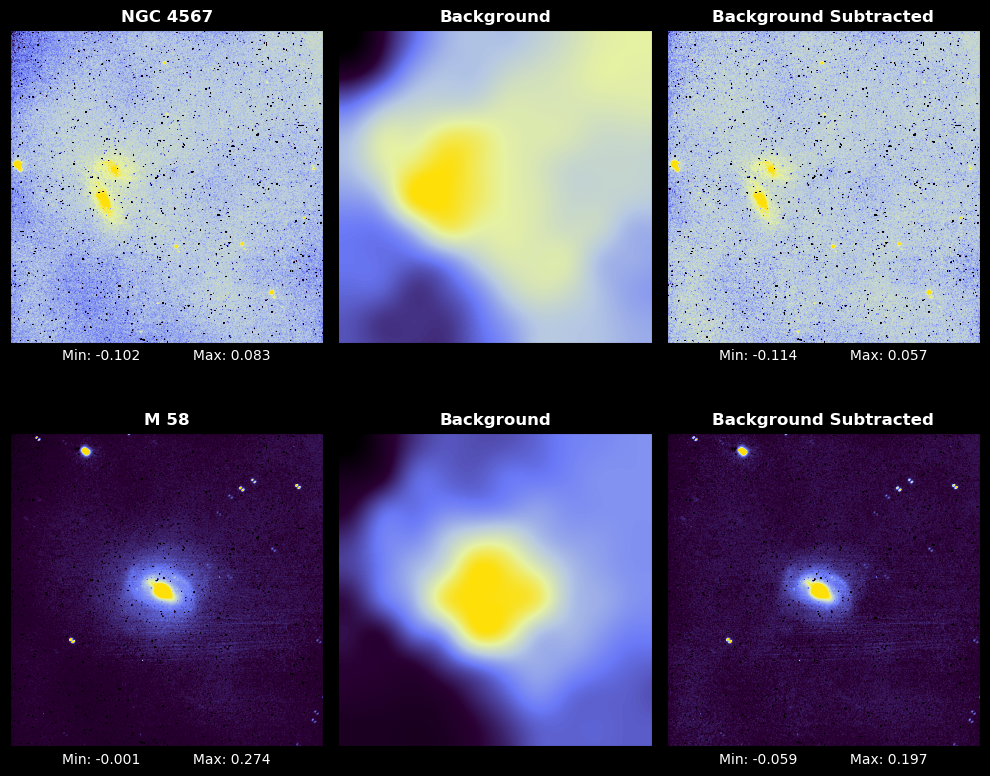

In [4]:
ngc_sfr = ngc4567['r'] - ngc4567['ha']
ngc_bkg = pb.Background2D(ngc_sfr, box_size=(100, 100), filter_size=(3, 3), sigma_clip=SigmaClip(sigma=3),
                    mask=(ngc_sfr == 0), bkg_estimator=pb.MedianBackground())

m_sfr = m58['r'] - m58['ha']
m_bkg = pb.Background2D(m_sfr, box_size=(100, 100), filter_size=(3, 3), sigma_clip=SigmaClip(sigma=3),
                    mask=(m_sfr == 0), bkg_estimator=pb.MedianBackground())

data_sets = [
    (ngc_sfr, ngc_bkg, 'NGC 4567'),
    (m_sfr, m_bkg, 'M 58')
]

fig, axes = plt.subplots(2, 3, figsize=(10, 8), facecolor='black')

for i, (sfr, bkg, title) in enumerate(data_sets):
    vmin, vmax = np.percentile(sfr, [1, 99.75])
    vnorm = vis.ImageNormalize(sfr, vmin=vmin, vmax=vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())
    axes[i, 0].imshow(sfr, cmap=ccm, norm=vnorm, interpolation='hermite')
    axes[i, 0].set_title(title, weight='bold', color='white')
    axes[i, 0].set_xlabel(f'Min: {vmin:.3f}            Max: {vmax:.3f}', color='white')

    axes[i, 1].imshow(bkg.background, cmap=ccm, interpolation='hermite')
    axes[i, 1].set_title('Background', weight='bold', color='white')

    sfr_sub = sfr - bkg.background
    vmin, vmax = np.percentile(sfr_sub, [1, 99.75])
    vnorm = vis.ImageNormalize(sfr_sub, vmin=vmin, vmax=vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())
    axes[i, 2].imshow(sfr_sub, cmap=ccm, norm=vnorm, interpolation='hermite')
    axes[i, 2].set_title('Background Subtracted', weight='bold', color='white')
    axes[i, 2].set_xlabel(f'Min: {vmin:.3f}            Max: {vmax:.3f}', color='white')

    data_sets[i] = (sfr_sub, bkg, title)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

ngc_sfr = ngc_sfr - ngc_bkg.background
m_sfr = m_sfr - m_bkg.background

In [5]:
# selecting a portion of the region to get a set of stars
x_start, x_end = 160, 495
y_start, y_end = 360, 695
ngc_snip = ngc_sfr[y_start:y_end, x_start:x_end]
print(f"Shape: {ngc_snip.shape} pixels")

ngc_snip_mean, ngc_snip_median, ngc_snip_std = sigma_clipped_stats(ngc_snip, sigma=3)
print(f"Mean: {ngc_snip_mean:.3f}", f"\nMedian: {ngc_snip_median:.3f}", f"\nStd: {ngc_snip_std:.3f}\n")

ngc_daofind = DAOStarFinder(fwhm=4, threshold=5.*ngc_snip_std) # fwhm=3 in example
                    #   fwhm: The full-width half-maximum (FWHM) of the major axis of the Gaussian kernel in units of pixels.
ngc_sources = ngc_daofind(ngc_snip - ngc_snip_median)

for col in ngc_sources.colnames:  
    if col not in ('id', 'xcentroid', 'ycentroid'):
        ngc_sources[col].format = '%.2f'  # for consistent table output

ngc_positions = np.transpose((ngc_sources['xcentroid'], ngc_sources['ycentroid']))
ngc_annuli = CircularAnnulus(ngc_positions, r_in=10, r_out=20)

Shape: (335, 335) pixels
Mean: 0.001 
Median: 0.004 
Std: 0.021



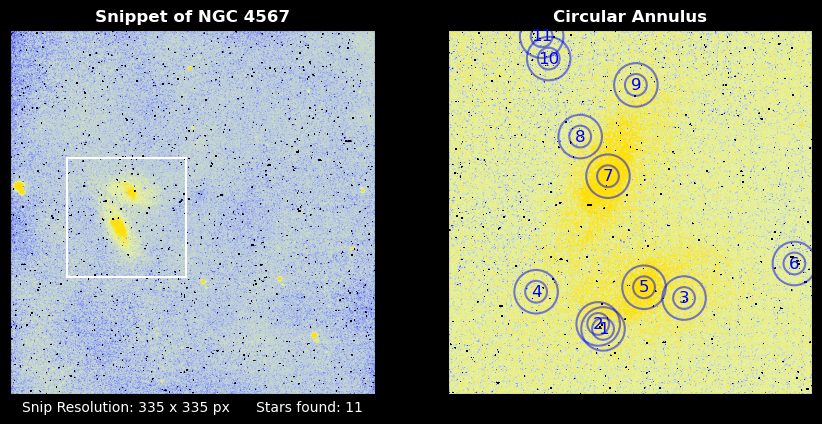

In [6]:
# viewing selection & apertures
with warnings.catch_warnings(): # booo warnings
    warnings.simplefilter('ignore')

    fig = plt.figure(figsize=(16, 9), facecolor='black')

    # plotting sfr image and marking the snippet -----------------------------------------
    plt.subplot(1, 3, 1)
    plt.title(f'Snippet of NGC 4567', weight='bold', color='white')
    plt.xlabel(f'Snip Resolution: {ngc_snip.shape[0]} x {ngc_snip.shape[1]} px      Stars found: {len(ngc_sources)}', color='white')
    
    vmin, vmax = np.percentile(ngc_sfr, [1, 99.75])
    vnorm = vis.ImageNormalize(ngc_sfr, vmin=vmin, vmax=vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())
    plt.imshow(ngc_sfr, cmap=ccm, norm=vnorm, interpolation='hermite')
    
    snip_width, snip_height = x_end - x_start, y_end - y_start
    extent = [x_start, x_start + snip_width, y_start, y_start + snip_height]
    rect = Rectangle((x_start, y_start), snip_width, snip_height, edgecolor='white', facecolor='none', lw=1.5)
    plt.gca().add_patch(rect)


    # plotting annului --------------------------------------------------------------
    norm = vis.ImageNormalize(ngc_snip, vmin=vmin, vmax=vmax, interval=vis.ZScaleInterval(), stretch=vis.SqrtStretch())

    plt.subplot(1, 3, 2)
    plt.imshow(ngc_snip, cmap=ccm, origin='lower', norm=norm, interpolation='hermite')
    ngc_annuli.plot(color='blue', lw=1.5, alpha=0.5)
    for i, (x, y) in enumerate(zip(ngc_sources['xcentroid'], ngc_sources['ycentroid'])):
        plt.text(x, y, f"{ngc_sources['id'][i]}", color='blue', fontsize=12, ha='center', va='center')
    plt.title(f'Circular Annulus', weight='bold', color='white')

    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

In [7]:
ngc_sources = ngc_sources[~np.isin(ngc_sources['id'], [11, 6, 1])]

# redeclaring everything again to make sure everything's on the same page
ngc_positions = np.transpose((ngc_sources['xcentroid'], ngc_sources['ycentroid']))
ngc_apertures = CircularAperture(ngc_positions, r=10)
ngc_annuli = CircularAnnulus(ngc_positions, r_in=10, r_out=20)


ngc_phot_table = aperture_photometry(ngc_sfr, ngc_apertures)
ngc_phot_table['annulus_sum'] = aperture_photometry(ngc_sfr, ngc_annuli)['aperture_sum']

annuli_areas = pu.aperture.PixelAperture.area_overlap(ngc_annuli, ngc_sfr)

annustats = ApertureStats(ngc_sfr, ngc_annuli, sigma_clip=SigmaClip(sigma=3.0, maxiters=10))

# total background within the annulus
ngc_phot_table['annu_total_bkg'] = annustats.median * annuli_areas

# background-subtracted photometry
ngc_phot_table['annuli_sum_bkgsub'] = ngc_phot_table['annulus_sum'] - ngc_phot_table['annu_total_bkg']

print(f"Mean Annuli: {annustats.median}\n \n")

for col in ngc_phot_table.colnames:  
    if col not in ('id'):
        ngc_phot_table[col].format = '%.2f'  # for consistent table output

ngc_phot_table['id'] = ngc_sources['id']
ngc_phot_table.pprint(max_lines=13, max_width=200)

Mean Annuli: [-0.0051085  -0.00073529 -0.00666895 -0.00035985  0.00266695 -0.00068962
  0.00587416 -0.00096243]
 

 id      xcenter            ycenter       aperture_sum annulus_sum annu_total_bkg annuli_sum_bkgsub
           pix                pix                                                                  
--- ------------------ ------------------ ------------ ----------- -------------- -----------------
  2  137.7950554098001  64.27152196199076        -4.35      -12.95          -4.81             -8.14
  3 216.64888139253873  88.05205732393533        -2.65      -15.26          -0.69            -14.57
  4  80.75190381392842  93.83833500578672        -6.37      -19.30          -6.29            -13.01
  5 179.87490323617945  97.95699856829381        -2.84      -14.54          -0.34            -14.20
  7  146.7637516564575  199.9580568595561        -3.73       -9.90           2.51            -12.41
  8 121.23838094315283  236.3707648232261        -2.33      -10.46          -0.65    

In [8]:
for source_id in [5, 7]:
    source_row = ngc_sources[ngc_sources['id'] == source_id]
    x, y = np.round(source_row['xcentroid'][0], 2), np.round(source_row['ycentroid'][0], 2)
    phot_row = ngc_phot_table[(np.round(ngc_phot_table['xcenter'].value, 2) == x) & (np.round(ngc_phot_table['ycenter'].value, 2) == y)]

    print(f"[ID {source_id}] Magnitude: {phot_row['annuli_sum_bkgsub'][0]:.2f}")

[ID 5] Magnitude: -14.20
[ID 7] Magnitude: -12.41
